In [1]:
!pip install spectral
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
import os
import numpy as np
import spectral
import spectral.io.envi as envi
import sklearn
from sklearn.preprocessing import LabelEncoder

import cv2

Load the data

In [75]:
rgb_images = []  
hsi_images = []
labels = []


# Set the directory path for the hyperspectral images in your Google Drive
dir_path = 'hsi_samples'

stop = False

for dir_name in os.listdir(dir_path):
    if dir_name not in ['hyper_L' ,'hyper_N', 'hyper_P']:
        continue

    if (stop):
      break

    print(f'Processing images in directory {dir_name}...')

    if os.path.isdir(os.path.join(dir_path, dir_name)):
        # Get the corresponding RGB directory name
        rgb_dir_name = dir_name.replace('hyper_', '../rgb&hyper/Choledoch_RGB/Choledoch_RGB/')

        # Loop over all image files in the directory
        for file_name in os.listdir(os.path.join(dir_path, dir_name)):


            if file_name.endswith('.hdr'):
                # Load the HSI image file
                hsi_file_path = os.path.join(dir_path, dir_name, file_name)
                hsi_image = envi.open(hsi_file_path, hsi_file_path[:-4] + '.raw')

                # Preprocess the HSI image
                hsi_data = hsi_image.load()
                height, width = hsi_image.shape[:2]
                hsi_data = hsi_data.reshape(height, width, -1)
                hsi_data_min = np.min(hsi_data)
                hsi_data_max = np.max(hsi_data)
                hsi_data = (hsi_data - hsi_data_min) / (hsi_data_max - hsi_data_min)

                # Load the corresponding RGB image file
                rgb_file_name = os.path.splitext(file_name)[0] + '.jpg'
                rgb_file_path = os.path.join(dir_path, rgb_dir_name, rgb_file_name)
                if not os.path.exists(rgb_file_path):
                  rgb_file_name = rgb_file_name[:6] + 'C' + rgb_file_name[7:]
                  rgb_file_path = os.path.join(dir_path, rgb_dir_name, rgb_file_name)
                
                if not os.path.exists(rgb_file_path):
                  continue
                  
                rgb_image = cv2.imread(rgb_file_path)
                print(rgb_dir_name)
                print(rgb_file_name)

                # Preprocess the RGB image
                rgb_data = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
                rgb_data = rgb_data.astype(np.float32) / 255.0

                # Append the preprocessed HSI and RGB images to their respective lists
                hsi_images.append(hsi_data)
                rgb_images.append(rgb_data)
                labels.append(dir_name)

Processing images in directory hyper_L...
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/L
042145-20x-roi2.jpg
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/L
042189c_2-20x-roi2.jpg
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/L
042189c_2-20x-roi3.jpg
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/L
042189c_2-20x-roi4.jpg
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/L
042189c_2-20x-roi6.jpg
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/L
042189c_2-20x-roi7.jpg
Processing images in directory hyper_N...
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/N
030968-20x-roi2.jpg
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/N
030968-20x-roi3.jpg
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/N
030968-20x-roi4.jpg
Processing images in directory hyper_P...
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/P
2tata0302-20x-roi1.jpg
../rgb&hyper/Choledoch_RGB/Choledoch_RGB/P
2tata0302-20x-roi2.jpg


Label Encoder

In [76]:
# Create a label encoder object
le = LabelEncoder()

# Fit the label encoder to the labels and transform them to integers
labels = le.fit_transform(labels)

In [77]:
import tensorflow as tf

Load pre-trained RGB and HSI models

In [78]:
rgb_model = tf.keras.models.load_model('rgb model.h5')
hsi_model = tf.keras.models.load_model('hsi model.h5')

In [79]:
hsi_images=np.array(hsi_images)
rgb_images=np.array(rgb_images)
labels=np.array(labels)

In [80]:
print(rgb_images.shape)
print(hsi_images.shape)
print(labels.shape)


(11, 1728, 2304, 3)
(11, 1024, 1280, 60)
(11,)


In [81]:
rgb_images = np.resize(rgb_images, (11,1024, 1280, 60))
hsi_images=np.resize(hsi_images,(11,70, 70, 60, 1))

In [243]:
print(rgb_images.shape)
print(hsi_images.shape)


(11, 1024, 1280, 60)
(11, 70, 70, 60, 1)


In [244]:
rgb_base_model = tf.keras.models.Model(inputs=rgb_model.input, outputs=rgb_model.layers[-2].output)
hsi_base_model = tf.keras.models.Model(inputs=hsi_model.input, outputs=hsi_model.layers[-2].output)

In [245]:
for layer in rgb_base_model.layers:
    layer.trainable = False

for layer in hsi_base_model.layers:
    layer.trainable = False

In [281]:

rgb_input=rgb_model.input
hsi_input=hsi_model.input
print(rgb_input.shape)
print(hsi_input.shape)

(None, 1024, 1280, 60)
(None, 70, 70, 60, 1)


In [282]:
rgb_features = rgb_base_model(rgb_input)
hsi_features = hsi_base_model(hsi_input)

In [283]:
fusion = Concatenate()([rgb_features, hsi_features])

Add a fully connected layer

In [284]:
x = Dense(64, activation='relu')(fusion)
x = Dense(16, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# Add the output layer (3 classes)
output = Dense(3, activation='softmax')(x)

Deep Fusion Network Model

In [285]:
# Create the DFN model
dfn_model = Model(inputs=[rgb_input, hsi_input], outputs=output)

# Compile the model
dfn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
dfn_model.summary()

Model: "model_62"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1280,  0           []                               
                                 60)]                                                             
                                                                                                  
 conv3d_input (InputLayer)      [(None, 70, 70, 60,  0           []                               
                                 1)]                                                              
                                                                                                  
 model_54 (Functional)          (None, 50)           81814       ['input_1[0][0]']                
                                                                                           

Train the model

In [286]:
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=3)
history = dfn_model.fit([rgb_images, hsi_images], one_hot_labels, epochs=5, batch_size=1, shuffle=True)

Epoch 1/5
11/11 [==============================] - 3s 188ms/step - loss: 1.5152 - accuracy: 0.2727
Epoch 2/5
11/11 [==============================] - 2s 177ms/step - loss: 1.3515 - accuracy: 0.2727
Epoch 3/5
11/11 [==============================] - 2s 182ms/step - loss: 1.2963 - accuracy: 0.4545
Epoch 4/5
11/11 [==============================] - 2s 177ms/step - loss: 1.2679 - accuracy: 0.5455
Epoch 5/5
11/11 [==============================] - 2s 175ms/step - loss: 1.2321 - accuracy: 0.5455


Plot training metrics

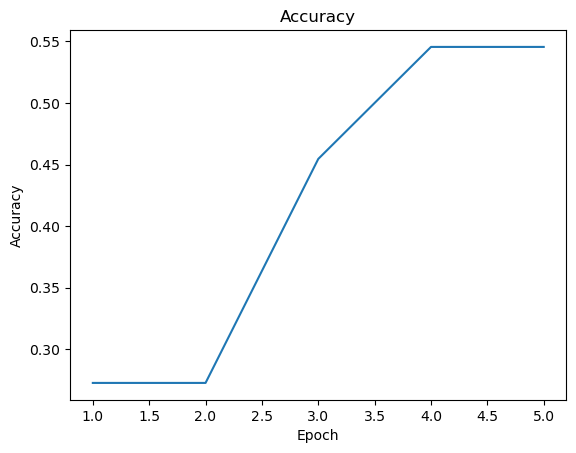

In [287]:
plt.plot(range(1, len(history.history["accuracy"]) + 1), history.history["accuracy"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()